In [ ]:
import pandas as pd
#import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set()

In [ ]:
df = pd.read_csv('/content/Index2018 (1).csv')
df.head()

,FECHA,USD,EUR,GBP,JPY
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


**DataFrame limpio y preparado** con fechas como índice en frecuencia diaria hábil, sin valores faltantes, listo para usar en modelos de series temporales.

In [ ]:
## Preprocesamiento
df['date'] = pd.to_datetime(df['date'], dayfirst=True) ## objeto dataframe del tipo dd/mm/yyyy
df.set_index('date', inplace=True)  ## define date como el indice
df = df.asfreq('b')    ##días hábiles (b = business days).
df = df.fillna(method='ffill')  ##Rellena valores faltantes con el del dia anterior
df.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


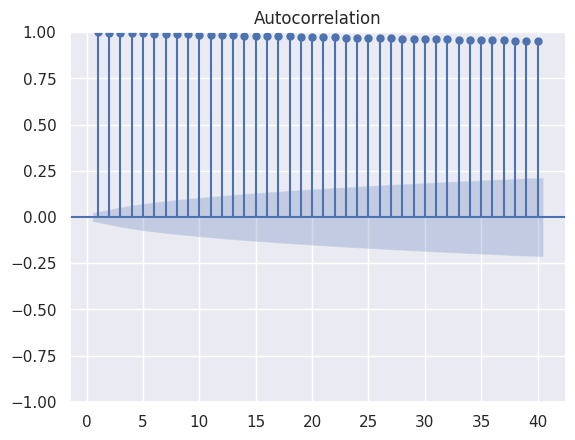

In [ ]:
sgt.plot_acf(df["spx"], lags=40, zero=False)
plt.show()

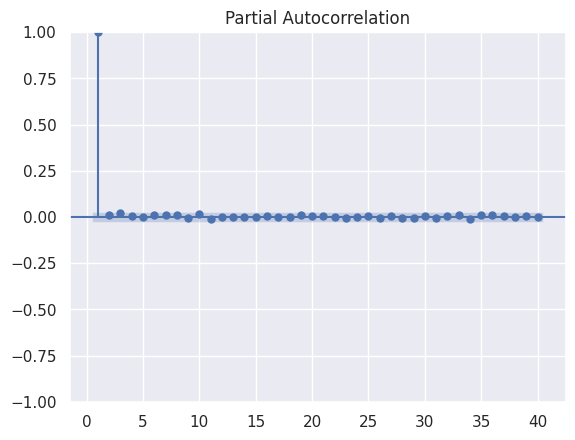

In [ ]:
sgt.plot_pacf(df["spx"], lags=40, zero=False)
plt.show()

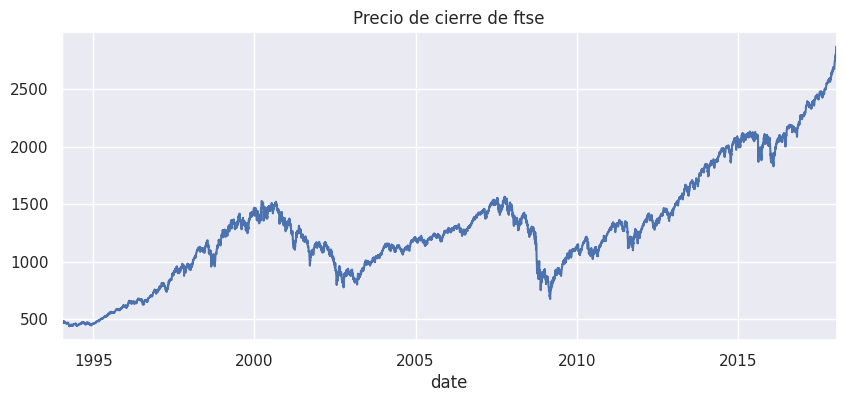

In [ ]:
## serie normal
df['spx'].plot(figsize=(10, 4), title='Precio de cierre de ftse')
plt.show()

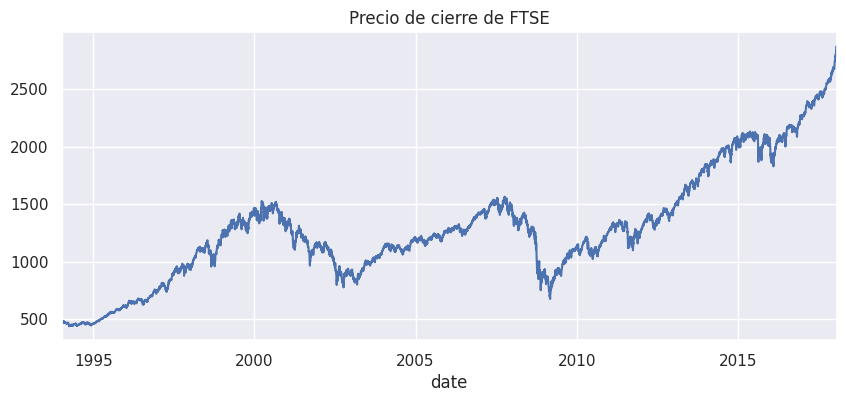

In [ ]:
##retonos
df['retornos'] = df['spx'].pct_change()  # cambio porcentual simple
Retorno = df['spx'].dropna()
df['spx'].plot(figsize=(10, 4), title='Precio de cierre de FTSE')
plt.show()

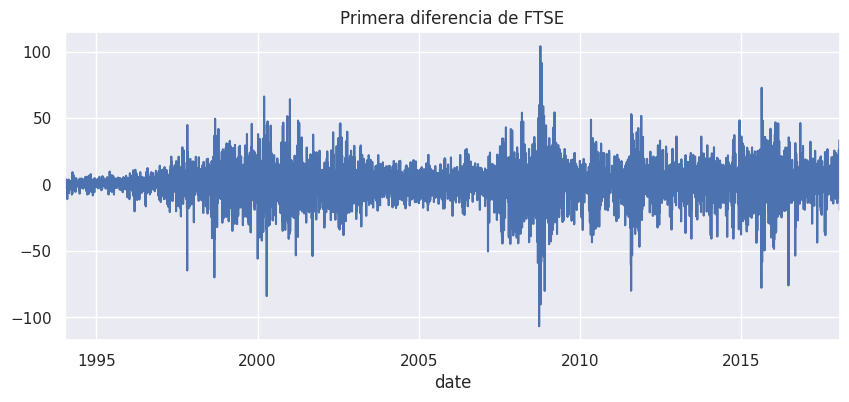

In [ ]:
## primera diferencia
df['diff1'] = df['spx'].diff(1)
df['diff1'].plot(figsize=(10, 4), title='Primera diferencia de FTSE')
plt.show()

El primer número (1) es el número de rezagos autorregresivos (AR).

El segundo (1) es el número de diferencias (I, integración) para hacer la serie estacionaria.

El tercero (1) es el número de términos de media móvil (MA).

In [ ]:
##ARIMA
modelo111 = ARIMA(df['spx'], order=(1, 1, 1))
resultado111 = modelo111.fit()
print(resultado111.summary())

                               SARIMAX Results                                
Dep. Variable:                    spx   No. Observations:                 6277
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -25249.679
Date:                Wed, 17 Sep 2025   AIC                          50505.357
Time:                        15:19:49   BIC                          50525.591
Sample:                    01-07-1994   HQIC                         50512.368
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6389      0.062     10.333      0.000       0.518       0.760
ma.L1         -0.6951      0.057    -12.204      0.000      -0.807      -0.583
sigma2       182.8286      1.741    104.999      0.0

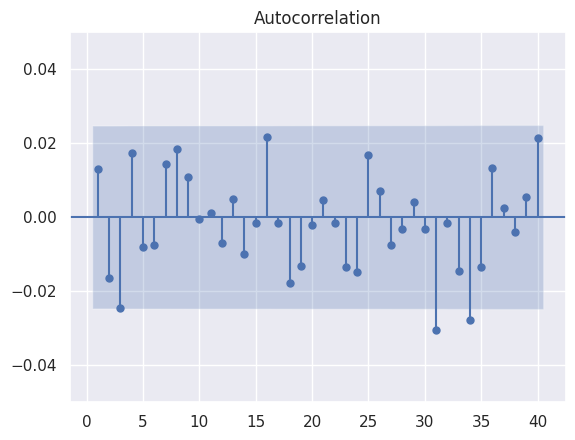

In [ ]:
df['resi111'] = resultado111.resid
sgt.plot_acf(df['resi111'], zero=False, lags=40)
plt.ylim(-0.05, 0.05)
plt.show()

In [ ]:
# Modelo 111
M111 = ARIMA(df['spx'], order=(1,1,1)).fit()

tiempo = 30  # horizonte
fc = M111.get_forecast(steps=tiempo)

prediccion = fc.predicted_mean.rename("pronostico")
ci   = fc.conf_int()
ci.columns = ["ic_95_inf", "ic_95_sup"]
tabla_fc = pd.concat([prediccion, ci], axis=1)
print(tabla_fc.head(10))


             pronostico    ic_95_inf    ic_95_sup
2018-01-30  2852.840437  2826.338957  2879.341918
2018-01-31  2852.400891  2815.960099  2888.841683
2018-02-01  2852.120065  2808.452719  2895.787410
2018-02-02  2851.940645  2802.373961  2901.507328
2018-02-05  2851.826013  2797.156035  2906.495991
2018-02-06  2851.752775  2792.512832  2910.992718
2018-02-07  2851.705983  2788.281026  2915.130940
2018-02-08  2851.676088  2784.359677  2918.992499
2018-02-09  2851.656988  2780.682642  2922.631334
2018-02-12  2851.644785  2777.204487  2926.085083


In [ ]:
## creemos varios modelos
modelo112 = ARIMA(df['spx'], order=(1, 1, 2))
resultado112 = modelo112.fit()

modelo113 = ARIMA(df['spx'], order=(1, 1, 3))
resultado113 = modelo113.fit()

modelo211 = ARIMA(df['spx'], order=(2, 1, 1))
resultado211 = modelo211.fit()

modelo311 = ARIMA(df['spx'], order=(3, 1, 1))
resultado311 = modelo311.fit()

modelo312 = ARIMA(df['spx'], order=(3, 1, 2))
resultado312 = modelo312.fit()

In [ ]:
print(f"ARIMA(1,1,1)\tAIC = {resultado111.aic:.3f}  BIC = {resultado111.bic:.3f}")
print(f"ARIMA(1,1,2)\tAIC = {resultado112.aic:.3f}  BIC = {resultado112.bic:.3f}")
print(f"ARIMA(1,1,3)\tAIC = {resultado113.aic:.3f}  BIC = {resultado113.bic:.3f}")
print(f"ARIMA(2,1,1)\tAIC = {resultado211.aic:.3f}  BIC = {resultado211.bic:.3f}")
print(f"ARIMA(3,1,1)\tAIC = {resultado311.aic:.3f}  BIC = {resultado311.bic:.3f}")
print(f"ARIMA(3,1,2)\tAIC = {resultado312.aic:.3f}  BIC = {resultado312.bic:.3f}")

ARIMA(1,1,1)	AIC = 68842.619  BIC = 68862.852
ARIMA(1,1,2)	AIC = 68836.516  BIC = 68863.494
ARIMA(1,1,3)	AIC = 68832.598  BIC = 68866.321
ARIMA(2,1,1)	AIC = 68836.221  BIC = 68863.199
ARIMA(3,1,1)	AIC = 68835.560  BIC = 68869.282
ARIMA(3,1,2)	AIC = 68834.764  BIC = 68875.231


Mejor por AIC es el ARIMA(1,1,3) con un AIC = 68832.598 (es el más bajo). sin embargo por por BIC es el ARIMA(1,1,2) con BIC = 68863.494, aunque la diferencia con ARIMA(1,1,1) y ARIMA(2,1,1) es mínima.

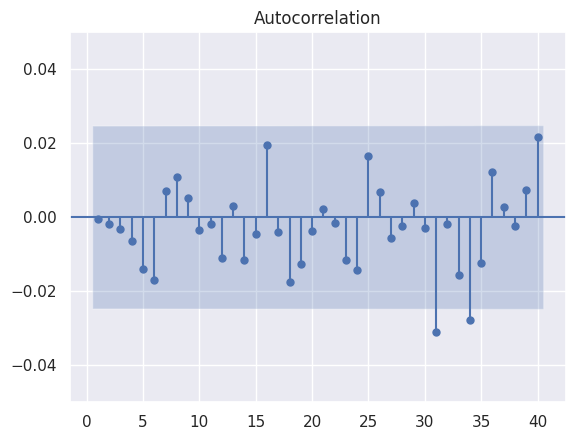

In [ ]:
df['resi113'] = resultado113.resid
sgt.plot_acf(df['resi113'], zero=False, lags=40)
plt.ylim(-0.05, 0.05)
plt.show()

In [ ]:
# Modelo 113
M113 = ARIMA(df['ftse'], order=(1,1,3)).fit()
tiempo = 30  # horizonte
fc = M113.get_forecast(steps=tiempo)

prediccion = fc.predicted_mean.rename("pronostico")
ci   = fc.conf_int()
ci.columns = ["ic_95_inf", "ic_95_sup"]
tabla_fc = pd.concat([prediccion, ci], axis=1)
print(tabla_fc.head(10))


             pronostico    ic_95_inf    ic_95_sup
2018-01-30  7669.119292  7554.974911  7783.263674
2018-01-31  7666.431673  7505.953929  7826.909417
2018-02-01  7667.332004  7474.461122  7860.202886
2018-02-02  7667.044986  7449.670494  7884.419477
2018-02-05  7667.136485  7426.847899  7907.425070
2018-02-06  7667.107315  7406.174289  7928.040342
2018-02-07  7667.116614  7386.977626  7947.255603
2018-02-08  7667.113650  7369.027242  7965.200058
2018-02-09  7667.114595  7352.094481  7982.134709
2018-02-12  7667.114294  7336.027599  7998.200988


In [ ]:
#!pip uninstall -y pmdarima numpy
#!pip install numpy==1.26.4
#!pip install pmdarima==2.0.4
#import pmdarima as pm

In [ ]:
modeloauto1 = pm.auto_arima(df['ftse'], seasonal=False, stepwise=False,
                            suppress_warnings=True, trace=True)
print(modeloauto1.summary())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=68864.160, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=68865.557, Time=0.90 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=68852.667, Time=1.68 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=68833.310, Time=2.21 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=68834.683, Time=1.60 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=68829.823, Time=1.91 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=68865.614, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=68843.279, Time=4.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=68837.312, Time=6.58 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=68833.570, Time=4.17 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=68835.394, Time=10.43 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=68853.247, Time=1.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=68837.025, Time=4.85 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=68838.795, Time=7.88 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=68834.027, Time=6.2

In [ ]:
MMM015 = ARIMA(df['ftse'], order=(0,1,5)).fit()

tiempo = 30  # horizonte
fc = MMM015.get_forecast(steps=tiempo)

prediccion = fc.predicted_mean.rename("pronostico")
ci   = fc.conf_int()
ci.columns = ["ic_95_inf", "ic_95_sup"]
tabla_fc = pd.concat([prediccion, ci], axis=1)
print(tabla_fc.head(10))


             pronostico    ic_95_inf    ic_95_sup
2018-01-30  7669.468525  7555.279378  7783.657672
2018-01-31  7669.420283  7508.997043  7829.843522
2018-02-01  7670.982630  7478.100704  7863.864555
2018-02-02  7669.403594  7451.890094  7886.917094
2018-02-05  7669.426839  7429.273567  7909.580110
2018-02-06  7669.426839  7410.056228  7928.797449
2018-02-07  7669.426839  7392.167693  7946.685984
2018-02-08  7669.426839  7375.365359  7963.488319
2018-02-09  7669.426839  7359.472529  7979.381148
2018-02-12  7669.426839  7344.355778  7994.497899


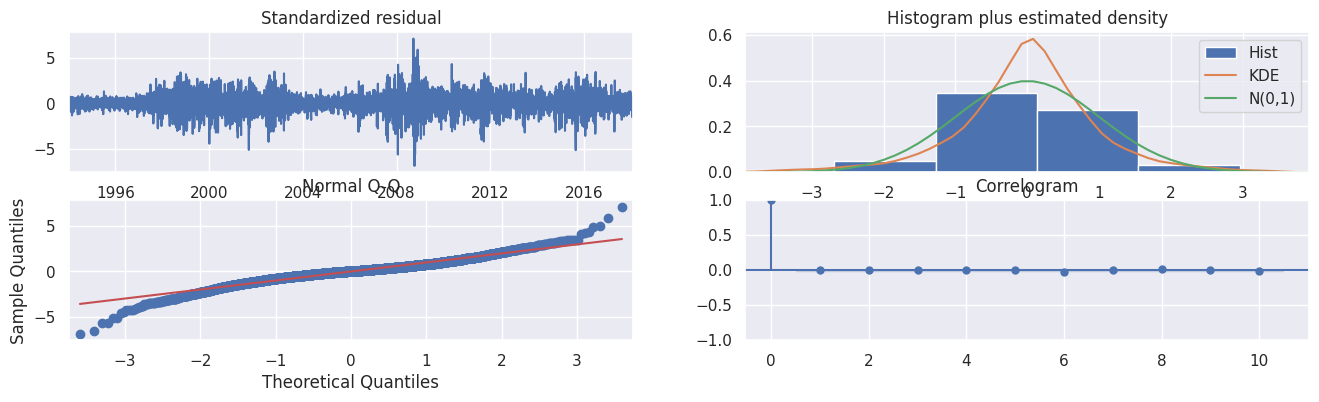

In [ ]:
modeloauto1.plot_diagnostics(figsize=(16,4))
plt.show()

In [ ]:
modeloauto2 = pm.auto_arima(Retorno, seasonal=False, stepwise=False, suppress_warnings=True)
print(modeloauto2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6276
Model:               SARIMAX(5, 0, 0)   Log Likelihood               19338.254
Date:                Sun, 14 Sep 2025   AIC                         -38664.507
Time:                        02:15:57   BIC                         -38624.040
Sample:                    01-10-1994   HQIC                        -38650.486
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0177      0.008     -2.250      0.024      -0.033      -0.002
ar.L2         -0.0516      0.007     -7.390      0.000      -0.065      -0.038
ar.L3         -0.0692      0.007    -10.014      0.0

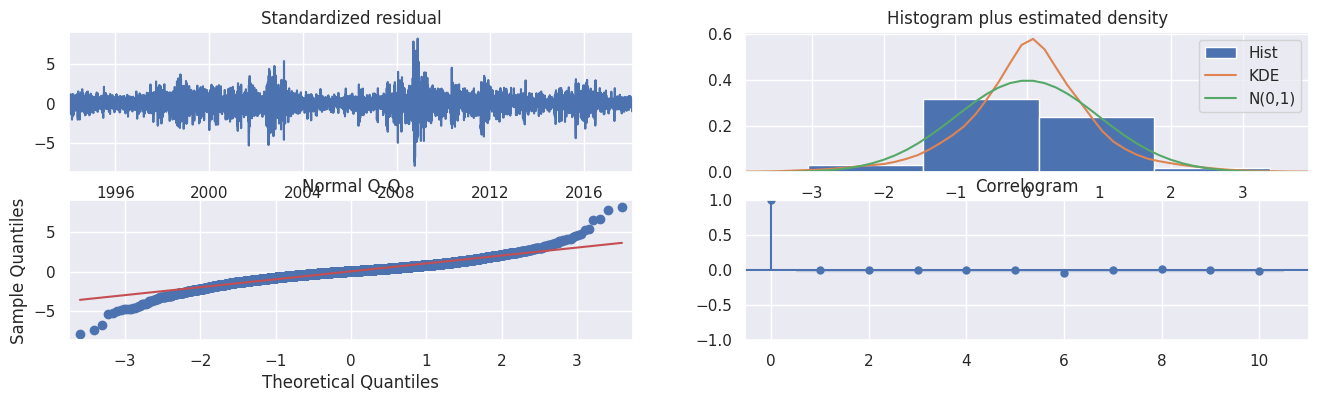

In [ ]:
modeloauto2.plot_diagnostics(figsize=(16,4))
plt.show()

In [ ]:
MMMRETORNO = ARIMA(Retorno, order=(5,0,0)).fit()

tiempo = 30  # horizonte
fc = MMMRETORNO.get_forecast(steps=tiempo)

prediccion = fc.predicted_mean.rename("pronostico")
ci   = fc.conf_int()
ci.columns = ["ic_95_inf", "ic_95_sup"]
tabla_fc = pd.concat([prediccion, ci], axis=1)
print(tabla_fc.head(10))


            pronostico  ic_95_inf  ic_95_sup
2018-01-30   -0.000341  -0.022106   0.021423
2018-01-31    0.000286  -0.021482   0.022054
2018-02-01    0.000580  -0.021217   0.022377
2018-02-02   -0.000134  -0.021981   0.021712
2018-02-05    0.000118  -0.021742   0.021978
2018-02-06    0.000214  -0.021675   0.022102
2018-02-07    0.000221  -0.021668   0.022110
2018-02-08    0.000160  -0.021729   0.022049
2018-02-09    0.000203  -0.021687   0.022093
2018-02-12    0.000193  -0.021697   0.022083


In [ ]:
##SARIMA

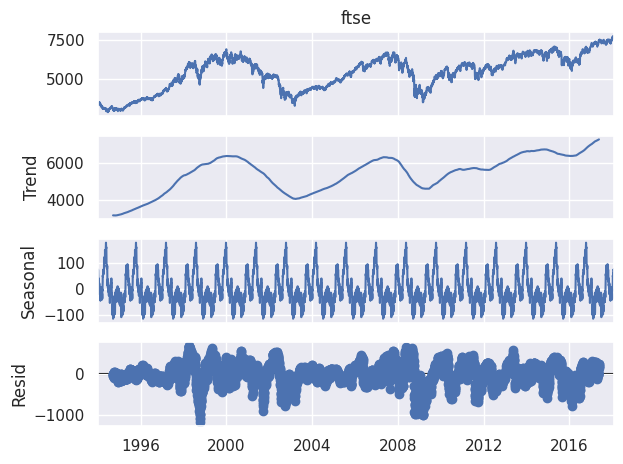

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
deadi = seasonal_decompose(df['ftse'], period=365)
deadi.plot()
plt.show()

In [ ]:
modelo111s = SARIMAX(df['ftse'], order=(1,1,1), seasonal_order=(1,1,1,5),trend="c")             # opcional: drift/constante
resultado111s = modelo111s.fit()
print(resultado111s.summary())

                                     SARIMAX Results                                     
Dep. Variable:                              ftse   No. Observations:                 6277
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 5)   Log Likelihood              -34408.278
Date:                           Sun, 14 Sep 2025   AIC                          68828.557
Time:                                   02:16:25   BIC                          68869.019
Sample:                               01-07-1994   HQIC                         68842.577
                                    - 01-29-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.462e-05      0.000      0.095      0.924      -0.001       0.001
ar.L1          0.8039      0.053     15.096

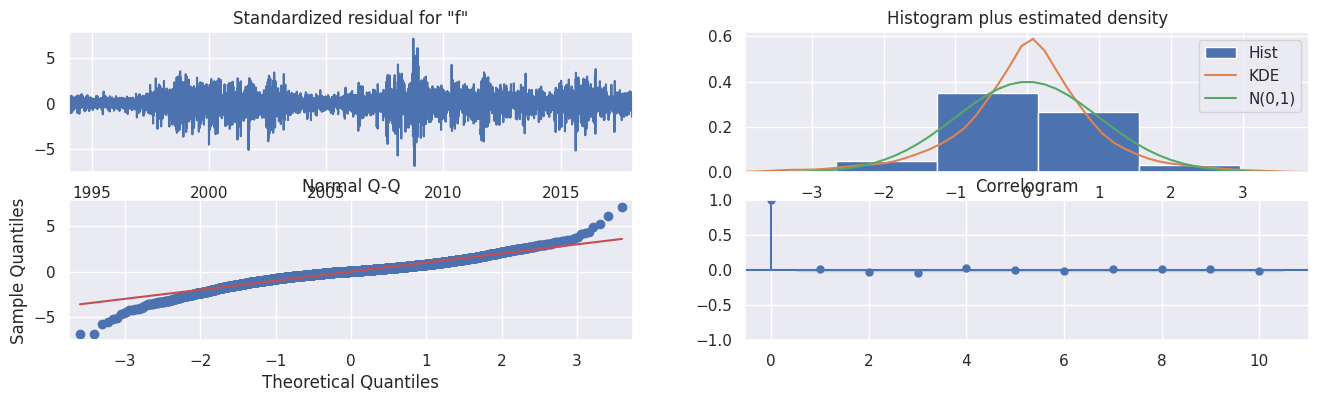

In [ ]:
resultado111s.plot_diagnostics(figsize=(16,4))
plt.show()

In [ ]:
MSEASONAL = SARIMAX(df["ftse"],order=(1,1,1), seasonal_order=(1,1,1,5)).fit()
tiempo = 30  # horizonte
fc = MSEASONAL.get_forecast(steps=tiempo)

prediccion = fc.predicted_mean.rename("pronostico")
ci   = fc.conf_int()
ci.columns = ["ic_95_inf", "ic_95_sup"]
tabla_fc = pd.concat([prediccion, ci], axis=1)
print(tabla_fc.head(10))


             pronostico    ic_95_inf    ic_95_sup
2018-01-30  7674.006698  7559.759009  7788.254388
2018-01-31  7675.228655  7516.399890  7834.057419
2018-02-01  7676.618553  7485.002633  7868.234474
2018-02-02  7678.242918  7459.905321  7896.580515
2018-02-05  7678.505459  7437.248722  7919.762196
2018-02-06  7680.749460  7420.062444  7941.436476
2018-02-07  7679.726869  7401.396009  7958.057728
2018-02-08  7680.192586  7385.598532  7974.786640
2018-02-09  7682.532698  7372.775155  7992.290242
2018-02-12  7682.697867  7358.674219  8006.721515


In [ ]:
modeloauto1s = pm.auto_arima(df["ftse"], seasonal=True, m=5, stepwise=True,
                             suppress_warnings=True, trace=True)
print(modeloauto1s.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=68837.551, Time=18.59 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=68864.160, Time=0.28 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=68860.271, Time=1.33 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=68860.048, Time=1.54 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=68862.995, Time=0.23 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=68836.439, Time=9.82 sec
 ARIMA(2,1,2)(0,0,0)[5] intercept   : AIC=68838.795, Time=8.52 sec
 ARIMA(2,1,2)(0,0,2)[5] intercept   : AIC=68837.742, Time=14.50 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=68836.603, Time=4.74 sec
 ARIMA(2,1,2)(1,0,2)[5] intercept   : AIC=68839.805, Time=17.00 sec
 ARIMA(1,1,2)(0,0,1)[5] intercept   : AIC=68835.998, Time=8.06 sec
 ARIMA(1,1,2)(0,0,0)[5] intercept   : AIC=68837.312, Time=4.98 sec
 ARIMA(1,1,2)(1,0,1)[5] intercept   : AIC=68837.220, Time=23.04 sec
 ARIMA(1,1,2)(0,0,2)[5] intercept   : AIC=68837.374, Time=11.95 sec
 ARIMA(1,1,2)(

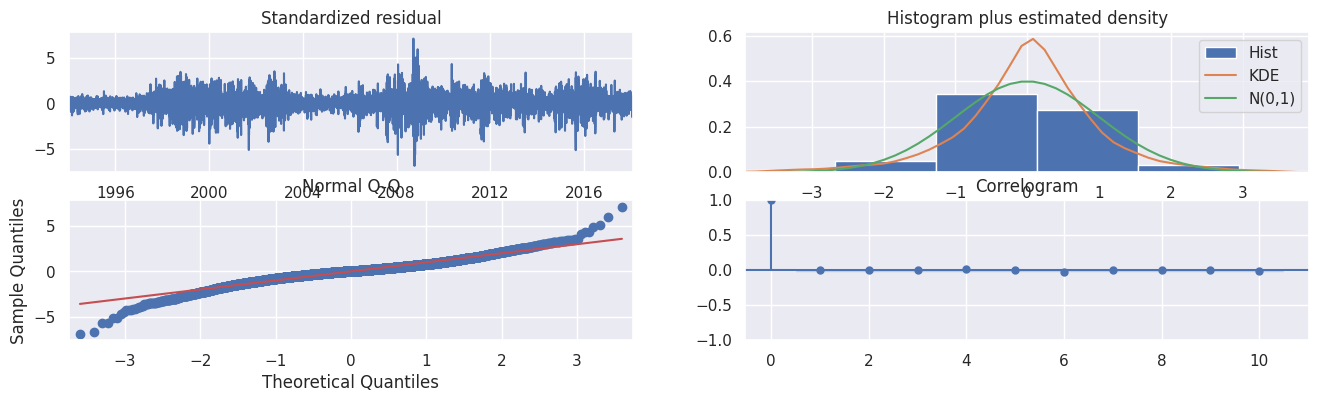

In [ ]:
modeloauto1s.plot_diagnostics(figsize=(16,4))
plt.show()

In [ ]:
MAMA = SARIMAX(df["ftse"],order=(0,1,3), seasonal_order=(0,0,1,5)).fit()
tiempo = 30  # horizonte
fc = MAMA.get_forecast(steps=tiempo)

prediccion = fc.predicted_mean.rename("pronostico")
ci   = fc.conf_int()
ci.columns = ["ic_95_inf", "ic_95_sup"]
tabla_fc = pd.concat([prediccion, ci], axis=1)
print(tabla_fc.head(10))


             pronostico    ic_95_inf    ic_95_sup
2018-01-30  7670.403600  7556.202436  7784.604765
2018-01-31  7670.754972  7510.200513  7831.309430
2018-02-01  7671.745252  7478.665453  7864.825051
2018-02-02  7670.030597  7452.274948  7887.786246
2018-02-05  7669.845999  7429.939275  7909.752724
2018-02-06  7669.865930  7411.156558  7928.575302
2018-02-07  7669.956201  7393.705106  7946.207296
2018-02-08  7669.955174  7377.148857  7962.761491
2018-02-09  7669.955174  7361.410990  7978.499358
2018-02-12  7669.955174  7346.437805  7993.472542


In [ ]:
modeloauto4s = pm.auto_arima(df["ftse"], exogenous=df[["spx"]], seasonal=True, m=5,
    stepwise=True, suppress_warnings=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=68837.551, Time=19.66 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=68864.160, Time=0.29 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=68860.271, Time=1.37 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=68860.048, Time=2.44 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=68862.995, Time=0.41 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=68836.439, Time=8.57 sec
 ARIMA(2,1,2)(0,0,0)[5] intercept   : AIC=68838.795, Time=8.13 sec
 ARIMA(2,1,2)(0,0,2)[5] intercept   : AIC=68837.742, Time=14.60 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=68836.603, Time=4.74 sec
 ARIMA(2,1,2)(1,0,2)[5] intercept   : AIC=68839.805, Time=18.44 sec
 ARIMA(1,1,2)(0,0,1)[5] intercept   : AIC=68835.998, Time=6.70 sec
 ARIMA(1,1,2)(0,0,0)[5] intercept   : AIC=68837.312, Time=6.62 sec
 ARIMA(1,1,2)(1,0,1)[5] intercept   : AIC=68837.220, Time=21.99 sec
 ARIMA(1,1,2)(0,0,2)[5] intercept   : AIC=68837.374, Time=12.53 sec
 ARIMA(1,1,2)(

In [ ]:
print(modeloauto4s.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 6277
Model:             SARIMAX(0, 1, 3)x(0, 0, [1], 5)   Log Likelihood              -34408.715
Date:                             Sun, 14 Sep 2025   AIC                          68827.430
Time:                                     02:26:05   BIC                          68861.153
Sample:                                 01-07-1994   HQIC                         68839.115
                                      - 01-29-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0118      0.009     -1.338      0.181      -0.029       0.005
ma.L2         -0.0491      